In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_pvs_pf = pd.read_csv('data/TB_pvsage_pf.csv', parse_dates=['Date'])
df_nex_pf = pd.read_csv('data/TB_nex_pf.csv', parse_dates=['Date'])

In [3]:
df_pvs_pf['project'] = 'PVSAGE'
df_nex_pf['project'] = 'NEX'

In [4]:
df_nex_pf.columns

Index(['Site', 'Disturbance', 'Exclosure', 'Date', 'Total Hits', 'hits_C4',
       'hits_C3', 'hits_AnnGrass', 'hits_Forb', 'hits_Brome', 'hits_VUOC',
       'hits_Subshrub', 'hits_SD', 'hits_Total', 'weight_Total', 'weight_C4',
       'weight_C3', 'weight_Forb', 'weight_Brome', 'weight_VUOC',
       'weight_AnnGrass', 'weight_Subshrub', 'weight_SD', 'Year', 'project'],
      dtype='object')

In [5]:
fg_list = ['C4', 'C3', 'Brome', 'VUOC', 'Forb', 'SD']

In [6]:
df_pf = pd.concat([df_pvs_pf, df_nex_pf])

In [7]:
scale = False
if scale:
    df_pf = df_pf.apply(lambda x: np.power(x, 0.5) if 'weight' in x.name else x, axis=0)

In [8]:
df_pf['Total_Hits_FG'] = df_pf.loc[:, df_pf.columns.str.contains('hits_') & 
                                   [any(fg in c for fg in fg_list) for c in df_pf.columns]].sum(axis=1)

df_pf['Total_Weight_FG'] = df_pf.loc[:, df_pf.columns.str.contains('weight_') & 
                                   [any(fg in c for fg in fg_list) for c in df_pf.columns]].sum(axis=1)

In [9]:
# save data to disk for Lauren
df_pf.to_csv('data/TB_PinFrame_NEX_PVSAGE.csv', index=False)

In [10]:
mod_total = smf.ols('Total_Weight_FG ~ Total_Hits_FG', data=df_pf).fit()

In [11]:
mod_total_fg = smf.ols('Total_Weight_FG ~ hits_C4 + hits_C3 + hits_Brome + hits_VUOC + hits_Forb + hits_SD', data=df_pf).fit()

In [12]:
mod_c4 = smf.ols('weight_C4 ~ hits_C4', data=df_pf).fit()
mod_c3 = smf.ols('weight_C3 ~ hits_C3', data=df_pf).fit()
mod_brome = smf.ols('weight_Brome ~ hits_Brome', data=df_pf).fit()
mod_vuoc = smf.ols('weight_VUOC ~ hits_VUOC', data=df_pf).fit()
mod_forb = smf.ols('weight_Forb ~ hits_Forb', data=df_pf).fit()
mod_sd = smf.ols('weight_SD ~ hits_SD', data=df_pf).fit()

In [13]:
df_pf['pred_Total_FG'] = mod_total_fg.predict()
df_pf['pred_Total'] = mod_total.predict()
df_pf['pred_Indv_FG'] = mod_c4.predict(df_pf['hits_C4']) + mod_c3.predict(df_pf['hits_C3']) + \
mod_brome.predict(df_pf['hits_Brome']) + mod_vuoc.predict(df_pf['hits_VUOC']) + mod_forb.predict(df_pf['hits_Forb']) + \
mod_sd.predict(df_pf['hits_SD'])

In [14]:
# convert to long format to be able to plot with hue as the FG
df_pf_long = pd.wide_to_long(df_pf.reset_index(), 
                                     stubnames=['hits', 'weight'], 
                                     i=['Site', 'Exclosure', 'Disturbance', 'Plot Name', 'Date'], 
                                     j='FG', 
                                     sep="_", 
                                     suffix=r'\w+').reset_index()

df_pf_pred_long = pd.wide_to_long(df_pf.reset_index(), 
                                     stubnames=['pred'], 
                                     i=['Site', 'Exclosure', 'Disturbance', 'Plot Name', 'Date'], 
                                     j='Type', 
                                     sep="_", 
                                     suffix=r'\w+').reset_index()

In [15]:
# save data to disk for Lauren
df_pf_long.drop(columns=['pred_Total_FG', 'pred_Total', 'pred_Indv_FG']).to_csv('data/TB_PinFrame_NEX_PVSAGE_long.csv', index=False)

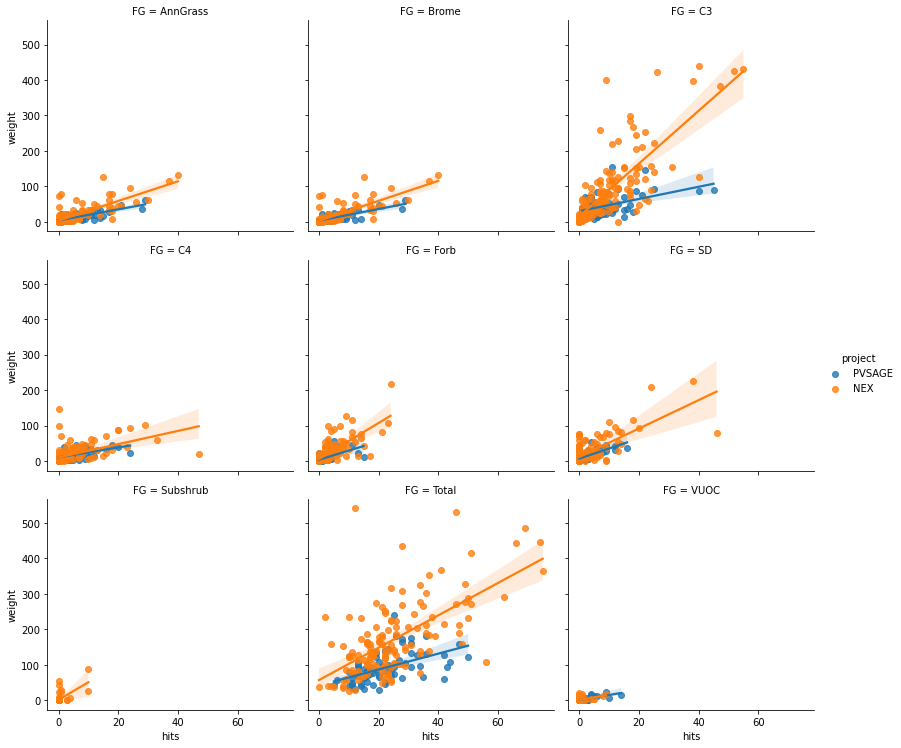

In [16]:
# plot linear fits for each functional group (FG)
sns.lmplot(x='hits',
           y='weight',
           col='FG',
           col_wrap=3,
           hue='project',
           data=df_pf_long,
           scatter=True, height=3.5, aspect=1.1)

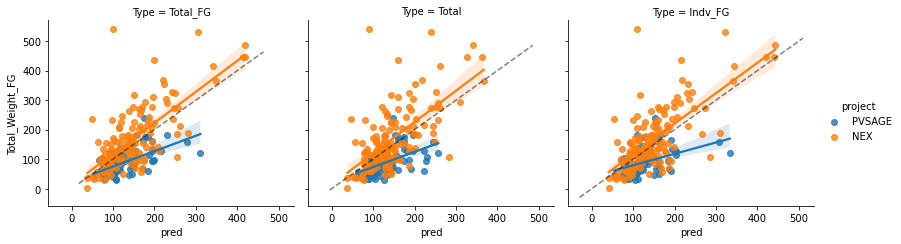

In [17]:
def abline(slope, intercept, axs, color='black', linewidth=None, kwargs={}):
    """Plot a line from slope and intercept"""
    if axs is not None:
        axes = axs
    else:
        axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    axes.plot(x_vals, y_vals, c=color, linewidth=linewidth, **kwargs)

    
# plot linear fits for each model type
g = sns.lmplot(x='pred',
           y='Total_Weight_FG',
           col='Type',
           col_wrap=3,
           hue='project',
           data=df_pf_pred_long,
           scatter=True, height=3.5, aspect=1.1)

for ax in g.axes:
    abline(1, 0, ax, color='black', kwargs={'linestyle': 'dashed', 'alpha': 0.5})

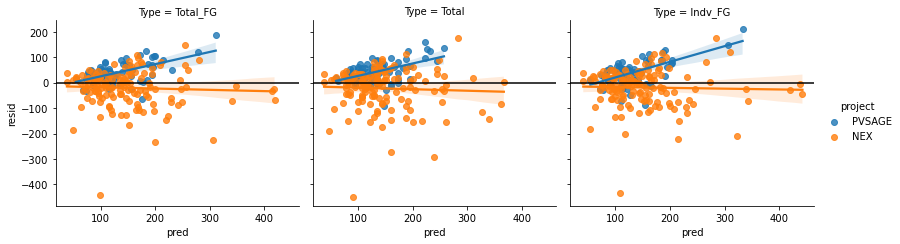

In [18]:
# calculate residuals
df_pf_pred_long['resid'] = df_pf_pred_long['pred'] - df_pf_pred_long['Total_Weight_FG']

# plot residuals for each model type
g = sns.lmplot(y='resid',
           x='pred',
           col='Type',
           col_wrap=3,
           hue='project',
           data=df_pf_pred_long,
           scatter=True, height=3.5, aspect=1.1)
for ax in g.axes:
    ax.axhline(y=0, linestyle='solid', c='black')

In [19]:
# explore outliers
df_pf_pred_long[df_pf_pred_long['resid'] < -400]

,Site,Exclosure,Disturbance,Plot Name,Date,Type,weight_C3,hits_VUOC,Total Hits,weight_Forb,...,hits_SD,hits_Subshrub,weight_Brome,hits_C3,weight_AnnGrass,hits_AnnGrass,weight_Subshrub,weight_Total,pred,resid
594,wildcat,ungulate ex,fire,NaN,2018-08-06,Total_FG,400.2,0,12,3.58,...,2,0.0,76.88,9,76.94,1,0.0,541.18,99.448247,-441.731753
595,wildcat,ungulate ex,fire,NaN,2018-08-06,Total,400.2,0,12,3.58,...,2,0.0,76.88,9,76.94,1,0.0,541.18,90.443636,-450.736364
596,wildcat,ungulate ex,fire,NaN,2018-08-06,Indv_FG,400.2,0,12,3.58,...,2,0.0,76.88,9,76.94,1,0.0,541.18,108.242767,-432.937233


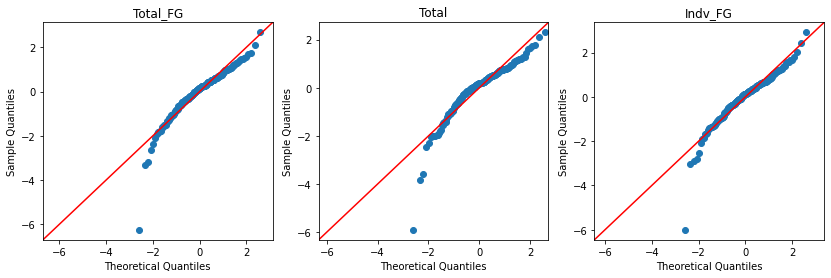

In [20]:
import statsmodels.api as sm
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))
for idx, type in enumerate(df_pf_pred_long['Type'].unique()):
    sm.qqplot(df_pf_pred_long.loc[df_pf_pred_long['Type'] == type, 'resid'], fit=True, line='45', ax=axs[idx])
    axs[idx].set_title(type)

In [21]:
# calculate weighted R^2-adj for individual FG models
fg_r2_weights = []
for fg in fg_list:
    fg_r2_weights.append(df_pf['weight_' + fg].sum()/df_pf['Total_Weight_FG'].sum())
fg_r2_avg = np.average([mod_c4.rsquared_adj, mod_c3.rsquared_adj,
                        mod_brome.rsquared_adj, mod_vuoc.rsquared_adj,
                        mod_forb.rsquared_adj, mod_sd.rsquared_adj],
        weights=fg_r2_weights)

In [22]:
print('\n----- Final adjusted/weighted R^2 -----\n')
print('Total weight by total hits = ' + str(round(mod_total.rsquared_adj, 2)))
print('Total weight by FG hits = ' + str(round(mod_total_fg.rsquared_adj, 2)))
print('Sum of FG weights by FG hits = ' + str(round(fg_r2_avg, 2)) + '  (weighted average)')

print('\n\n----- Final MAE ' + '(note: average weight = ' + str(round(df_pf['Total_Weight_FG'].mean(), 2)) + ')' + ' -----\n')
print('Total weight by total hits = ' + str(round(df_pf.apply(lambda x: abs(x['pred_Total'] - x['Total_Weight_FG']), axis=1).mean(), 2)))
print('Total weight by FG hits = ' + str(round(df_pf.apply(lambda x: abs(x['pred_Total_FG'] - x['Total_Weight_FG']), axis=1).mean(), 2)))
print('Sum of FG weights by FG hits = ' + str(round(df_pf.apply(lambda x: abs(x['pred_Indv_FG'] - x['Total_Weight_FG']), axis=1).mean(), 2)))

print('\n\n----- Final MRAE -----\n')
print('Total weight by total hits = ' + str(round(df_pf.apply(lambda x: abs((x['pred_Total'] - x['Total_Weight_FG']) / x['Total_Weight_FG']), axis=1).mean(), 2)))
print('Total weight by FG hits = ' + str(round(df_pf.apply(lambda x: abs((x['pred_Total_FG'] - x['Total_Weight_FG']) / x['Total_Weight_FG']), axis=1).mean(), 2)))
print('Sum of FG weights by FG hits = ' + str(round(df_pf.apply(lambda x: abs((x['pred_Indv_FG'] - x['Total_Weight_FG']) / x['Total_Weight_FG']), axis=1).mean(), 2)))


----- Final adjusted/weighted R^2 -----

Total weight by total hits = 0.37
Total weight by FG hits = 0.44
Sum of FG weights by FG hits = 0.49  (weighted average)


----- Final MAE (note: average weight = 141.97) -----

Total weight by total hits = 53.7
Total weight by FG hits = 50.84
Sum of FG weights by FG hits = 52.56


----- Final MRAE -----

Total weight by total hits = 0.58
Total weight by FG hits = 0.55
Sum of FG weights by FG hits = 0.59


In [23]:
print('\n----- adjusted R^2 for individual FG models -----\n')
print('C4 = ' + str(round(mod_c4.rsquared_adj, 2)))
print('C3 = ' + str(round(mod_c3.rsquared_adj, 2)))
print('Brome = ' + str(round(mod_brome.rsquared_adj, 2)))
print('VUOC = ' + str(round(mod_vuoc.rsquared_adj, 2)))
print('Forb = ' + str(round(mod_forb.rsquared_adj, 2)))
print('SD = ' + str(round(mod_sd.rsquared_adj, 2)))


----- adjusted R^2 for individual FG models -----

C4 = 0.28
C3 = 0.5
Brome = 0.63
VUOC = 0.41
Forb = 0.55
SD = 0.52


<AxesSubplot:>

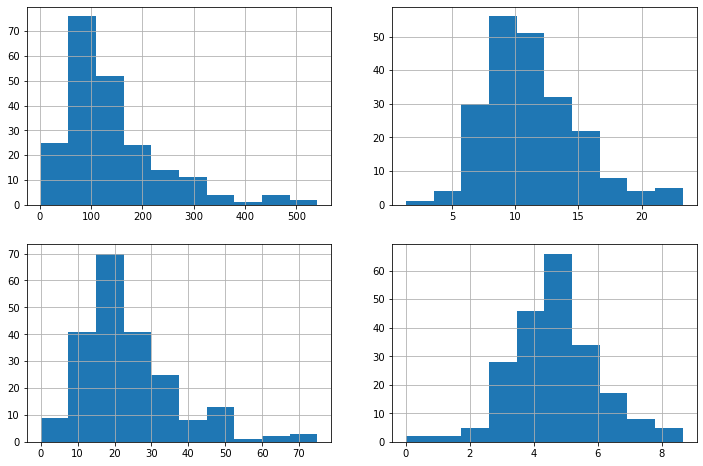

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
df_pf['Total_Weight_FG'].hist(ax=ax[0, 0])
df_pf['Total_Weight_FG'].transform(lambda x: np.power(x, 0.5)).hist(ax=ax[0, 1])
df_pf['Total_Hits_FG'].hist(ax=ax[1, 0])
df_pf['Total_Hits_FG'].transform(lambda x: np.power(x, 0.5)).hist(ax=ax[1, 1])

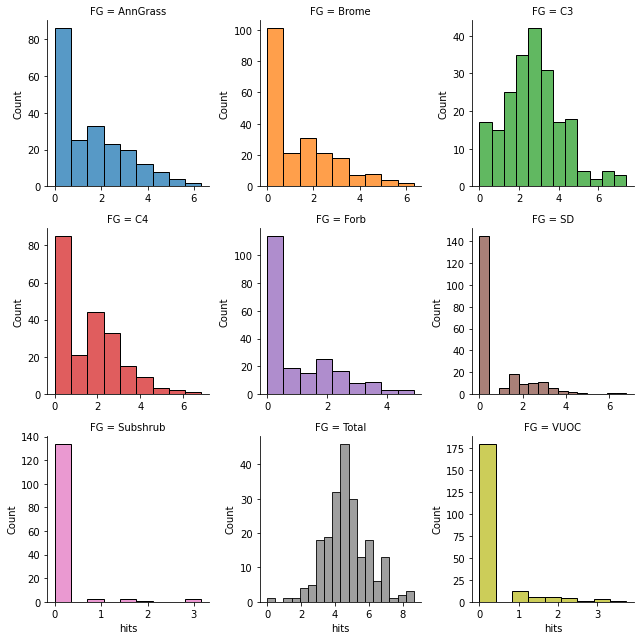

In [25]:
g = sns.FacetGrid(data=df_pf_long.apply(lambda x: np.power(x, 0.5) if x.dtype == 'float' else x, axis=0), hue='FG', col='FG', col_wrap=3, sharex=False, sharey=False)
g.map(sns.histplot, 'hits')

### other data
* PVSAGE ready next week
* NEX clipping will work - think about fences, which plots which will work with satellite training

### to do
* add in new data
* Separate transformations for each FG
* send organized data to Lauren